In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))
from pylab import rcParams
rcParams['figure.figsize'] = 22, 7
import matplotlib.pyplot as plt
import matplotx
plt.style.use(matplotx.styles.dracula)

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout 
import pandas_datareader.data as web
from datetime import date

In [ ]:
df = pd.read_csv('monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [ ]:
df.head()

In [ ]:
df.plot();

In [ ]:
results = seasonal_decompose(df['Production'])
results.plot();

In [ ]:
len(df)

In [ ]:
train = df.iloc[:156]
test = df.iloc[156:]

In [ ]:

scaler = MinMaxScaler()

In [ ]:
df.head(),df.tail()

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train[:10]

In [ ]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
X,y = generator[0]
X

In [ ]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

In [ ]:
X.shape

In [ ]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
%%time
# fit model
model.fit(generator,epochs=50)

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch = scaled_train[-n_input:]

In [ ]:
last_train_batch

In [ ]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [ ]:
model.predict(last_train_batch)

In [ ]:
scaled_test[0]

In [ ]:
first_eval_batch = scaled_train[-n_input:]
first_eval_batch.shape

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(len(test)):
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    # append the prediction into the array
    test_predictions.append(current_pred) 
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

In [ ]:
test.head()

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

In [ ]:
test.plot();

In [ ]:
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

### Creating Forecasting Class

In [10]:
#df = pd.read_csv('monthly_milk_production.csv',index_col='Date',parse_dates=True)
#df.index.freq='MS'

class Forecasting:
    def __init__ (self, n_input=12, layers=1, nodes=100, dropout=False, epochs=40, n_features=1, test_size=0.2, dropout_ratio=0.2):
        self.n_features = n_features
        self.n_input = n_input
        self.layers = layers
        self.nodes = nodes
        self.dropout = dropout
        self.epochs = epochs
        self.dropout_ratio = dropout_ratio
        self.test_size = test_size
        
    def preprocessing(self, df):
        cutt_off = int((len(df))*(1.0-self.test_size))
        train = df.iloc[:cutt_off]
        test = df.iloc[cutt_off:]
        scaler = MinMaxScaler()
        scaler.fit(train)
        scaled_train = scaler.transform(train)
        scaled_test = scaler.transform(test)
        generator = TimeseriesGenerator(scaled_train, scaled_train, length = self.n_input, batch_size = 1)
        return test, scaler, scaled_train, scaled_test, generator

    def create_model (self):
        model = Sequential()
        model.add(LSTM(self.nodes, activation='relu', return_sequences=True, input_shape=(self.n_input, self.n_features)))
        if self.layers > 1:
            for i in range(self.layers):
                model.add(LSTM(self.nodes, activation='relu', return_sequences=True))
                self.nodes+=int((self.nodes)*0.3)
                if self.dropout:
                    model.add(Dropout(self.dropout_ratio))
                    self.dropout_ratio += 0.1
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.summary()
        return model

    def fit_model(self,model,generator):
        model.fit(generator, epochs = self.epochs)
        loss_per_epoch = model.history.history['loss']
        plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
        return model
    def model_evaluation(self,model, scaled_train, test, scaler):
        test_predictions = []
        first_eval_batch = scaled_train[-self.n_input:]
        current_batch = first_eval_batch.reshape((1, self.n_input, self.n_features))
        for i in range(len(test)):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0][0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
            
        true_predictions = scaler.inverse_transform(test_predictions)
        test['Predictions'] = true_predictions
        rmse=sqrt(mean_squared_error(test[test.columns[0]],test['Predictions']))
        return test,rmse
    def forecast_future(self, model, scaler , scaled_train, days_to_be_forcasted=100):
        test_predictions = []
        first_eval_batch = scaled_train[-self.n_input:]
        current_batch = first_eval_batch.reshape((1, self.n_input, self.n_features))
        for i in range(days_to_be_forcasted):
            # get the prediction value for the first batch
            current_pred = model.predict(current_batch)[0][0]
            # append the prediction into the array
            test_predictions.append(current_pred) 
            # use the prediction to update the batch and remove the first value
            current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        predictions = scaler.inverse_transform(test_predictions)
        return predictions    

In [ ]:
forecast = Forecasting(n_input=12,layers=1, nodes=100, epochs=50, dropout=False)
test, scaler, scaled_train, scaled_test, generator = forecast.preprocessing(df)
model = forecast.create_model()
model = forecast.fit_model(model, generator)
test, rmse = forecast.model_evaluation(model, scaled_train, test, scaler)

In [ ]:
rmse 

In [ ]:
test

In [ ]:
plt.plot(test.Production, label = 'Actual Production')
plt.plot(test.Predictions,label= 'Predicted Production')
plt.legend();

In [16]:
today = date.today().strftime("%Y-%m-%d")
df = web.DataReader(name="TSLA", data_source='yahoo', start='2015-01-01', end='2020-01-01')
df = df[['Close']]
df

,Close
Date,
2015-01-02,43.862000
2015-01-05,42.018002
2015-01-06,42.256001
2015-01-07,42.189999
2015-01-08,42.124001
...,...
2019-12-24,85.050003
2019-12-26,86.188004
2019-12-27,86.075996


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100, 100)          40800     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 130)          120120    
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 130)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100, 169)          202800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 100, 169)         

<ipython-input-10-c7f2ab9ba9b8>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


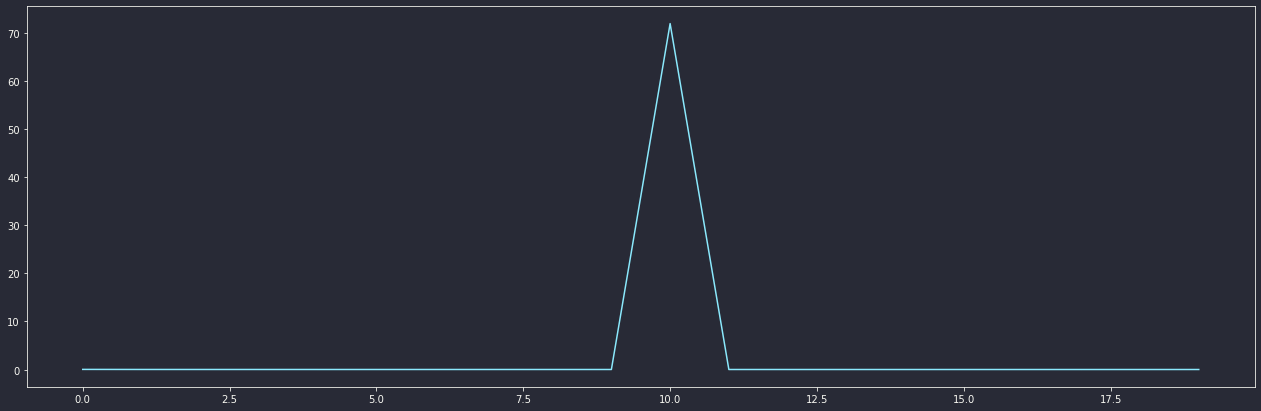

In [17]:
forecast = Forecasting(n_input=100, layers=3, nodes=100, epochs=20, dropout=True)
test, scaler, scaled_train, scaled_test, generator = forecast.preprocessing(df)
model = forecast.create_model()
model = forecast.fit_model(model, generator)
test, rmse = forecast.model_evaluation(model, scaled_train, test, scaler)

In [18]:
rmse

13.12666884877837

In [19]:
test

,Close,Predictions
Date,,
2019-01-02,62.023998,68.411573
2019-01-03,60.071999,65.368524
2019-01-04,63.537998,65.899797
2019-01-07,66.991997,66.061754
2019-01-08,67.070000,64.531364
...,...,...
2019-12-24,85.050003,52.058358
2019-12-26,86.188004,52.282320
2019-12-27,86.075996,52.218715


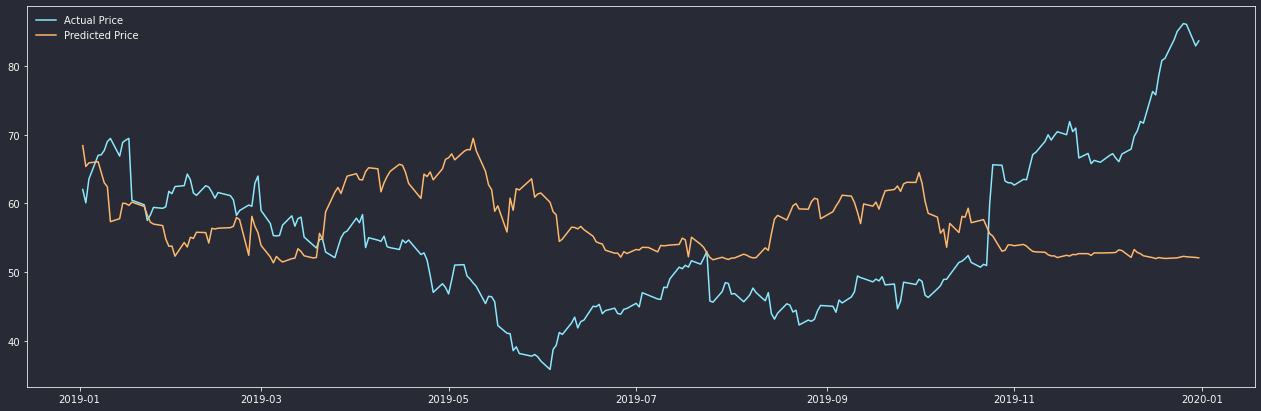

In [20]:
plt.plot(test.Close, label = 'Actual Price')
plt.plot(test.Predictions,label= 'Predicted Price')
plt.legend();

In [41]:
##Making Predictions for future
df1 = web.DataReader(name="TSLA", data_source='yahoo', start="2020-01-02", end = "2021-05-01")
df1 = df1[['Close']]
df1

,Close
Date,
2020-01-02,86.052002
2020-01-03,88.601997
2020-01-06,90.307999
2020-01-07,93.811996
2020-01-08,98.428001
...,...
2021-04-26,738.200012
2021-04-27,704.739990
2021-04-28,694.400024


In [42]:
predictions = forecast.forecast_future(model, scaler , scaled_train, days_to_be_forcasted=335)

In [43]:
df1['Predictions'] = predictions
df1

,Close,Predictions
Date,,
2020-01-02,86.052002,68.411573
2020-01-03,88.601997,65.368524
2020-01-06,90.307999,65.899797
2020-01-07,93.811996,66.061754
2020-01-08,98.428001,64.531364
...,...,...
2021-04-26,738.200012,52.351262
2021-04-27,704.739990,52.361226
2021-04-28,694.400024,52.368793


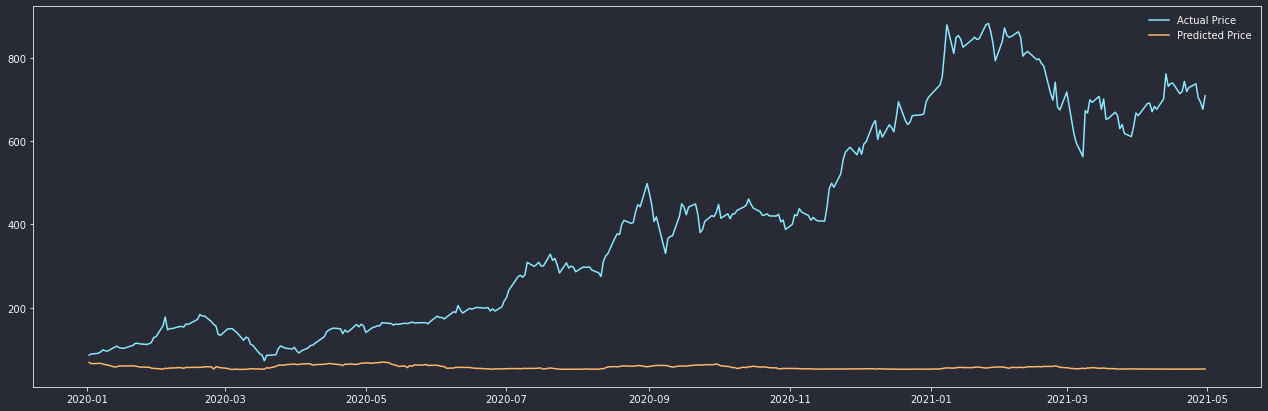

In [44]:
plt.plot(df1.Close, label = 'Actual Price')
plt.plot(df1.Predictions,label= 'Predicted Price')
plt.legend();